# 사용자 정의 데이터를 활용한 이미지 분류

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

'apt' is not recognized as an internal or external command,


* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
# 파이토치 관련 라이브러리

import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [4]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 데이터 준비

### 데이터 다운로드, 압축 해제, 트리 구조 출력

In [ ]:
# 데이터 다운로드
!wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# 압축 해제
!unzip -o hymenoptera_data.zip

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [3]:
# 트리 구조 출력
!tree hymenoptera_data

Folder PATH listing for volume 드라이브D
Volume serial number is 00000092 32BC:C9D8
D:\ONEDRIVE\DOCUMENTS\LECTURE_2019\ACADEMY\30_SPARKX\01_AI_BASIC\15_TRANSFER_LEARNING\HYMENOPTERA_DATA
├───train
│   ├───ants
│   └───bees
└───val
    ├───ants
    └───bees


### Transforms 정의

In [5]:
# Transforms 정의
# 훈련 데이터 : 정규화에 반전과 RandomErasing 추가
# 입력 이미지를 주어진 크기(resize: 224×224)로 조정, scale은 원래 이미지를 임의의 크기(0.5~1.0(50~100%))만큼 면적을 무작위로 자르겠다는 의미

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 검증 데이터 : 정규화
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

### 데이터셋 정의

In [6]:
# 베이스 디렉터리
data_dir = 'hymenoptera_data'

# 훈련 데이터 디렉터리와 검증 데이터 디렉터리 지정
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join 함수 결과 확인
print(train_dir, test_dir)

# 분류하려는 클래스의 리스트 작성
classes = ['ants', 'bees']

hymenoptera_data\train hymenoptera_data\val


In [7]:
# 데이터셋 정의

# 훈련용
train_data = datasets.ImageFolder(train_dir, 
                                  transform=train_transform)

# 검증용
test_data = datasets.ImageFolder(test_dir, 
                                 transform=test_transform)

In [8]:
# 데이터 건수 확인

print(f'훈련 데이터 : {len(train_data)} 건')
print(f'검증 데이터 : {len(test_data)} 건')

훈련 데이터 : 244 건
검증 데이터 : 153 건


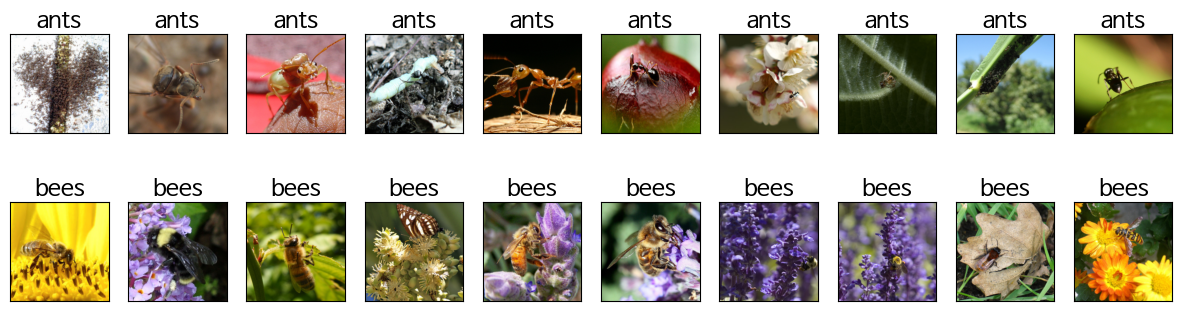

In [9]:
# 검증 데이터　
# 처음 10개와 마지막 10개 이미지 출력

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### 데이터로더 정의

In [10]:
# 데이터로더 정의

batch_size = 10

# 훈련용
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 검증용
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

## 파인 튜닝의 경우

In [11]:
# 파인 튜닝의 경우

# 사전 학습 모델 불러오기
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
# from torchvision import models
# net = models.vgg19_bn(pretrained = True)
weights = models.VGG19_BN_Weights.DEFAULT
net = models.vgg19_bn(weights = weights)

In [12]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
summary(net, (100, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [100, 1000]               --
├─Sequential: 1-1                        [100, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [100, 64, 224, 224]       1,792
│    └─BatchNorm2d: 2-2                  [100, 64, 224, 224]       128
│    └─ReLU: 2-3                         [100, 64, 224, 224]       --
│    └─Conv2d: 2-4                       [100, 64, 224, 224]       36,928
│    └─BatchNorm2d: 2-5                  [100, 64, 224, 224]       128
│    └─ReLU: 2-6                         [100, 64, 224, 224]       --
│    └─MaxPool2d: 2-7                    [100, 64, 112, 112]       --
│    └─Conv2d: 2-8                       [100, 128, 112, 112]      73,856
│    └─BatchNorm2d: 2-9                  [100, 128, 112, 112]      256
│    └─ReLU: 2-10                        [100, 128, 112, 112]      --
│    └─Conv2d: 2-11                      [100, 128, 112, 112]      147,

In [14]:

# 최종 노드의 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [15]:
# 학습
num_epochs = 5
from tqdm.notebook import tqdm

base_epochs = len(history) # => 0
batch_size_train = len(train_loader)
batch_size_test = len(test_loader)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 훈련 페이즈
    net.train() # dropout, batch normalization 활성화
    # count = 0

    for inputs, labels in tqdm(train_loader):
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        train_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_train_loss = train_loss / batch_size_train
    avg_train_acc = train_acc / batch_size_train

    # 예측 페이즈
    net.eval()
    # count = 0

    for inputs, labels in test_loader:
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        val_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_val_loss = val_loss / batch_size_test
    avg_val_acc = val_acc / batch_size_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.41614 acc: 0.81000 val_loss: 0.12931, val_acc: 0.96875


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.32149 acc: 0.86400 val_loss: 0.21110, val_acc: 0.91875


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.28313 acc: 0.88200 val_loss: 0.14535, val_acc: 0.94375


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.32477 acc: 0.85800 val_loss: 0.15448, val_acc: 0.93750


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.18807 acc: 0.92000 val_loss: 0.10091, val_acc: 0.96875


초기상태 : 손실 : 0.12931  정확도 : 0.96875
최종상태 : 손실 : 0.10091  정확도 : 0.96875


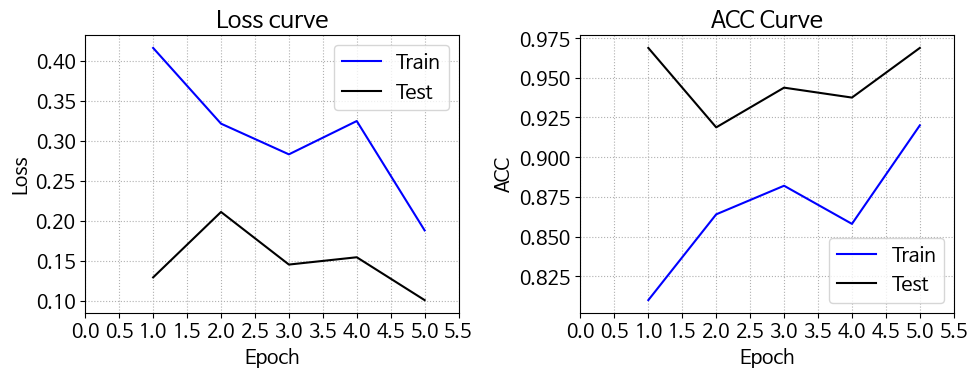

In [16]:
# 손실과 정확도 확인
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

num_epochs = len(history)
unit = num_epochs / 10

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# 학습 곡선 출력(손실)
# plt.figure(figsize=(9,8))
axs[0].plot(history[:,0], history[:,1], 'b', label='Train')
axs[0].plot(history[:,0], history[:,3], 'k', label='Test')
axs[0].set_xticks(np.arange(0,num_epochs+1, unit))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss curve')
axs[0].legend()


# 학습 곡선 출력(정확도)
# plt.figure(figsize=(9,8))
axs[1].plot(history[:,0], history[:,2], 'b', label='Train')
axs[1].plot(history[:,0], history[:,4], 'k', label='Test')
axs[1].set_xticks(np.arange(0,num_epochs+1,unit))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ACC')
axs[1].set_title('ACC Curve')
axs[1].legend()

plt.tight_layout()
plt.show()


## 전이 학습의 경우

In [17]:
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
# from torchvision import models
# net = models.vgg19_bn(pretrained = True)
weights = models.VGG19_BN_Weights.DEFAULT
net = models.vgg19_bn(weights = weights)

# 모든 파라미터의 경사 계산을 OFF로 설정
for param in net.parameters():
    param.requires_grad = False


# 최종 노드의 출력을 2로 변경
# 이 노드에 대해서만 경사 계산을 수행하게 됨
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수로 교차 엔트로피 사용
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [18]:
# 학습
# 학습
num_epochs = 5
from tqdm.notebook import tqdm

base_epochs = len(history) # => 0
batch_size_train = len(train_loader)
batch_size_test = len(test_loader)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 훈련 페이즈
    net.train() # dropout, batch normalization 활성화
    # count = 0

    for inputs, labels in tqdm(train_loader):
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        train_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_train_loss = train_loss / batch_size_train
    avg_train_acc = train_acc / batch_size_train

    # 예측 페이즈
    net.eval()
    # count = 0

    for inputs, labels in test_loader:
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        val_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_val_loss = val_loss / batch_size_test
    avg_val_acc = val_acc / batch_size_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.43375 acc: 0.79200 val_loss: 0.15307, val_acc: 0.95625


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.24426 acc: 0.89600 val_loss: 0.12543, val_acc: 0.96250


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.24404 acc: 0.90400 val_loss: 0.12535, val_acc: 0.95625


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.22668 acc: 0.90200 val_loss: 0.13021, val_acc: 0.95625


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.28944 acc: 0.87800 val_loss: 0.12881, val_acc: 0.96250


### 학습 결과 평가

초기상태 : 손실 : 0.15307  정확도 : 0.95625
최종상태 : 손실 : 0.12881  정확도 : 0.96250


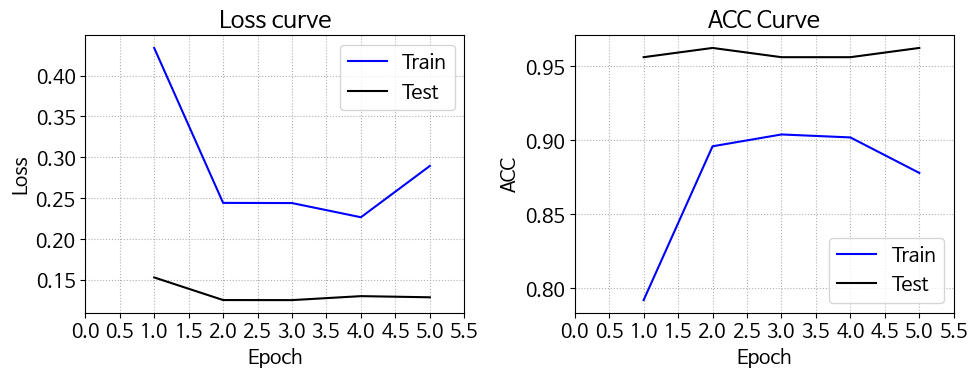

In [19]:
# 손실과 정확도 확인
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

num_epochs = len(history)
unit = num_epochs / 10

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# 학습 곡선 출력(손실)
# plt.figure(figsize=(9,8))
axs[0].plot(history[:,0], history[:,1], 'b', label='Train')
axs[0].plot(history[:,0], history[:,3], 'k', label='Test')
axs[0].set_xticks(np.arange(0,num_epochs+1, unit))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss curve')
axs[0].legend()


# 학습 곡선 출력(정확도)
# plt.figure(figsize=(9,8))
axs[1].plot(history[:,0], history[:,2], 'b', label='Train')
axs[1].plot(history[:,0], history[:,4], 'k', label='Test')
axs[1].set_xticks(np.arange(0,num_epochs+1,unit))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ACC')
axs[1].set_title('ACC Curve')
axs[1].legend()

plt.tight_layout()
plt.show()

## 시베리안 허스키와 늑대 이미지

### 데이터 다운로드, 압축 해제

In [ ]:
# 데이터 다운로드
!wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip


# 압축 해제
!unzip dog_wolf.zip | tail -n 1

# 트리 구조 확인
!tree dog_wolf

2022-04-10 14:43:13 (142 MB/s) - ‘dog_wolf.zip’ saved [21811374/21811374]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├─

### Transforms 정의

In [ ]:
# Transforms 정의

# 검증 데이터 : 정규화
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 훈련 데이터 : 정규화에 반전과 RandomErasing 추가
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

### 데이터셋 정의

In [ ]:
# 데이터셋 정의

data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)

test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# 데이터 건수 확인

print(f'학습 데이터 : {len(train_data)} 건')
print(f'검증 데이터 : {len(test_data)} 건')

학습 데이터 : 40 건
검증 데이터 : 10 건


### 데이터로더 정의

In [ ]:
# 데이터로더 정의

batch_size = 5
# 훈련 데이터
train_loader = DataLoader(train_data, 
            batch_size=batch_size, shuffle=True)

# 검증 데이터
test_loader = DataLoader(test_data, 
            batch_size=batch_size, shuffle=False)


### 모델 정의

In [ ]:
# 사전 학습 모델 불러오기
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False


# 마지막 노드 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [ ]:
# 학습
num_epochs = 5
from tqdm.notebook import tqdm

base_epochs = len(history) # => 0
batch_size_train = len(train_loader)
batch_size_test = len(test_loader)

for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # 훈련 페이즈
    net.train() # dropout, batch normalization 활성화
    # count = 0

    for inputs, labels in tqdm(train_loader):
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 경사 계산
        loss.backward()

        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        train_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_train_loss = train_loss / batch_size_train
    avg_train_acc = train_acc / batch_size_train

    # 예측 페이즈
    net.eval()
    # count = 0

    for inputs, labels in test_loader:
        # count += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 정답 건수 산출
        val_acc += (predicted == labels).sum().item() /len(labels)

        # 손실과 정확도 계산
    avg_val_loss = val_loss / batch_size_test
    avg_val_acc = val_acc / batch_size_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))

### 학습 결과 평가

In [ ]:

# 손실과 정확도 확인
print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}') 
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

num_epochs = len(history)
unit = num_epochs / 10

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# 학습 곡선 출력(손실)
# plt.figure(figsize=(9,8))
axs[0].plot(history[:,0], history[:,1], 'b', label='Train')
axs[0].plot(history[:,0], history[:,3], 'k', label='Test')
axs[0].set_xticks(np.arange(0,num_epochs+1, unit))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss curve')
axs[0].legend()


# 학습 곡선 출력(정확도)
# plt.figure(figsize=(9,8))
axs[1].plot(history[:,0], history[:,2], 'b', label='Train')
axs[1].plot(history[:,0], history[:,4], 'k', label='Test')
axs[1].set_xticks(np.arange(0,num_epochs+1,unit))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ACC')
axs[1].set_title('ACC Curve')
axs[1].legend()

plt.tight_layout()
plt.show()